In [137]:
import pandas as pd 
import numpy as np 
import os
import pandas as pd

desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "datafix.csv")
datafix = pd.read_csv(desktop_path)


In [138]:
datafix = datafix.set_index("Date")

In [139]:
datafix

,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,days_to_expiry,stock price,strike,rfr,type,IV,IVROC
Date,,,,,,,,,,,,,,,,,
2025-05-21 11:34:00,46.73,46.73,46.73,46.73,1.0,46.730000,NaN,0.000000,0.000000,0.000000,23.0,341.320,305,0.0429,c,0.734018,NaN
2025-05-21 14:05:00,41.06,41.06,41.06,41.06,1.0,41.533669,-11.119904,-0.452308,-0.090462,-0.361846,23.0,341.320,305,0.0429,c,0.499598,-31.936522
2025-05-21 15:09:00,38.78,38.78,38.78,38.78,1.0,38.414985,-7.508810,-0.983406,-0.269050,-0.714355,23.0,341.320,305,0.0429,c,0.376174,-24.704660
2025-05-22 12:06:00,44.96,44.96,44.96,44.96,1.0,41.842080,8.921246,-0.895310,-0.394302,-0.501007,22.0,342.800,305,0.0429,c,0.633346,68.364998
2025-05-22 12:55:00,45.55,45.55,45.55,45.55,1.0,43.804926,4.691082,-0.769020,-0.469246,-0.299774,22.0,343.630,305,0.0429,c,0.630036,-0.522632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-10 15:55:00,23.05,23.05,22.93,23.00,22.0,22.678029,0.362353,-0.072387,-0.003167,-0.069220,3.0,325.495,305,0.0429,c,0.814437,8.622597
2025-06-10 15:56:00,22.77,23.25,22.77,23.14,6.0,22.781463,0.456098,-0.041741,-0.010882,-0.030859,3.0,326.030,305,0.0429,c,0.773650,-5.008005
2025-06-10 15:57:00,23.25,23.30,23.25,23.30,8.0,22.906742,0.549918,-0.004491,-0.009604,0.005112,3.0,325.930,305,0.0429,c,0.806679,4.269252


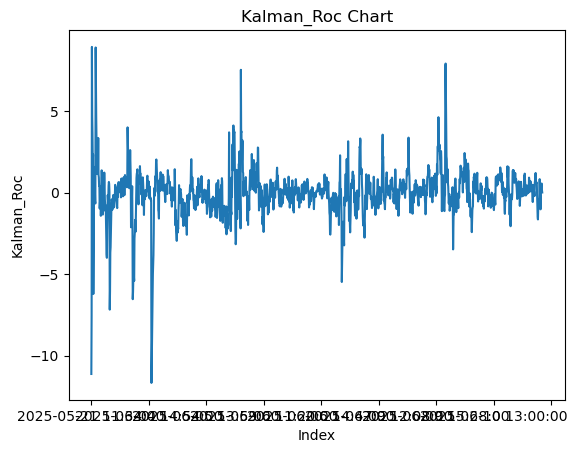

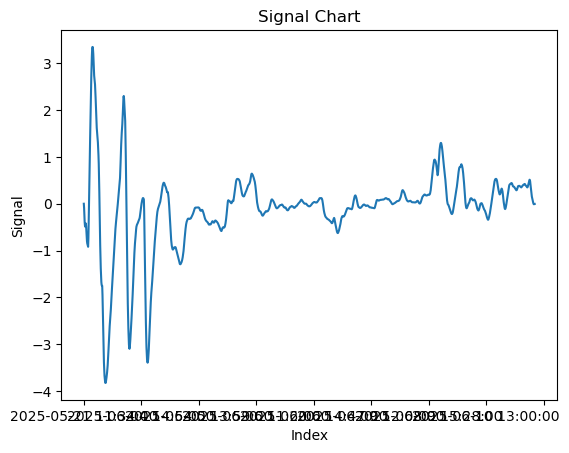

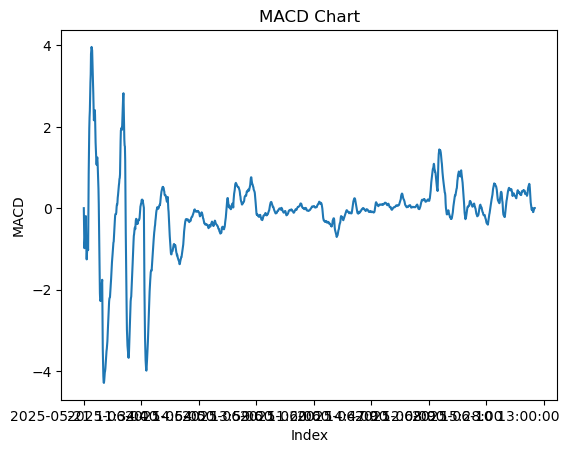

In [140]:
import matplotlib.pyplot as plt
def plot(name):
    column_to_plot = name  # Replace with your actual column name

    if column_to_plot in datafix.columns:
     datafix[column_to_plot].plot(kind='line', title=f"{column_to_plot} Chart")
     plt.xlabel("Index")
     plt.ylabel(column_to_plot)
     plt.show()
    else:
        print(f"Column '{column_to_plot}' not found in datafix DataFrame.")
plot("Kalman_Roc")
plot("Signal")
plot("MACD")

In [141]:
import numpy as np

buy_condition = (datafix["MACD_Hist"] > 0.15) & (datafix["Kalman_Roc"] > 0.1 )

datafix["Signal"] = None
datafix["max_gain"] = np.nan

in_position = False
current_max = np.nan
signals = [None] * len(datafix)

for int_idx, (df_idx, row) in enumerate(datafix.iterrows()):
    if not in_position:
        if buy_condition.loc[df_idx]:
            signals[int_idx] = "buy"
            in_position = True
            current_max = row["Close"]
            datafix.at[df_idx, "max_gain"] = current_max
    else:
        current_max = max(current_max, row["Close"])
        datafix.at[df_idx, "max_gain"] = current_max
        if row["Close"] < current_max * 0.80:
            signals[int_idx] = "sell"
            in_position = False
            current_max = np.nan

datafix["Signal"] = signals


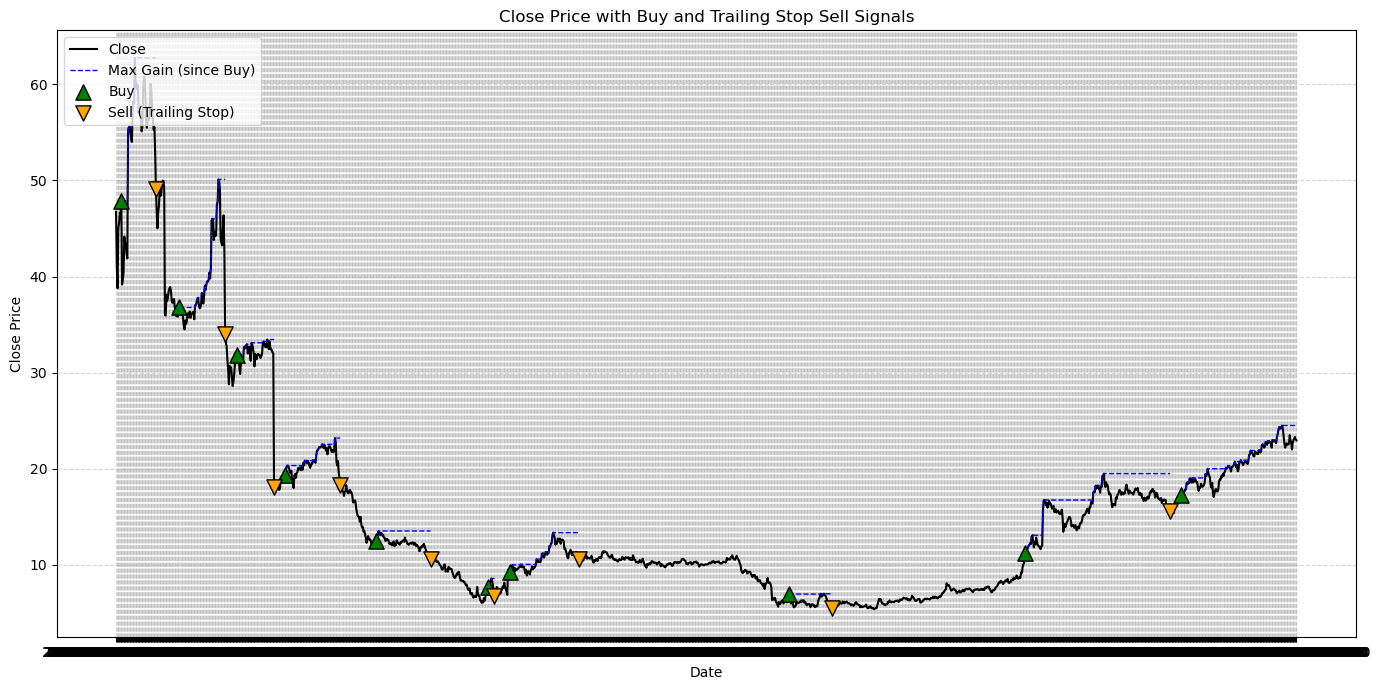

In [142]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot the Close price
plt.plot(datafix.index, datafix["Close"], label="Close", color="black", linewidth=1.5)

# (Optional) Plot the running max_gain as a blue dashed line
plt.plot(datafix.index, datafix["max_gain"], label="Max Gain (since Buy)", color="blue", linestyle="dashed", linewidth=1)

# Plot buy signals (green upward triangle)
buy_signals = datafix[datafix["Signal"] == "buy"]
plt.scatter(buy_signals.index, buy_signals["Close"], marker="^", color="green", edgecolor="black", s=120, label="Buy", zorder=3)

# Plot sell signals (orange downward triangle)
sell_signals = datafix[datafix["Signal"] == "sell"]
plt.scatter(sell_signals.index, sell_signals["Close"], marker="v", color="orange", edgecolor="black", s=120, label="Sell (Trailing Stop)", zorder=3)

plt.title("Close Price with Buy and Trailing Stop Sell Signals")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()



plt.show()
